In [1]:
import json
import os
from PIL import Image
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# Đường dẫn
json_path = "/mnt/VLAI_data/ViVQA-X/ViVQA-X_val.json"
coco_img_dir = "/mnt/VLAI_data/COCO_Images/val2014/"

# Đọc file JSON
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

samples = []
for item in data:
    img_path = os.path.join(coco_img_dir, item["image_name"])
    # Mở ảnh thành PIL Image
    image = Image.open(img_path).convert("RGB")
    sample = {
        "question": item["question"],
        "image": image,  # <-- PIL Image object
        "image_path": img_path,
        "explanation": item["explanation"],  # list
        "answer": item["answer"],
        "question_id": item["question_id"]
    }
    samples.append(sample)

In [ ]:
samples[4]

{'question': 'Người đàn ông đội mũ đang làm gì?',
 'image': <PIL.Image.Image image mode=RGB size=640x360>,
 'image_path': '/mnt/VLAI_data/COCO_Images/val2014/COCO_val2014_000000262531.jpg',
 'explanation': ['anh ấy đang cưỡi ván trượt',
  'anh ta cúi thấp trên một tấm ván có bánh xe',
  'anh ấy đang cưỡi ván trượt'],
 'answer': 'lướt ván',
 'question_id': '262531001'}

## Using Pos-tagging

In [ ]:
# Hàm trích xuất danh từ
def extract_nouns(text):
    normalized = text_normalize(text)
    tagged = pos_tag(normalized)
    nouns = [word for word, tag in tagged if tag in ['N', 'Np']]
    return nouns

# Xử lý tất cả samples
samples_with_nouns = []
for item in samples:
    img_path = os.path.join(coco_img_dir, item["image_name"])
    image = Image.open(img_path).convert("RGB")
    
    # Trích xuất danh từ từ câu hỏi
    question_nouns = extract_nouns(item["question"])
    
    # Trích xuất danh từ từ giải thích
    explanation_nouns = []
    for exp in item["explanation"]:
        explanation_nouns.extend(extract_nouns(exp))
    
    sample = {
        "question": item["question"],
        "question_nouns": question_nouns,
        "image": image,
        "image_path": img_path,
        "explanation": item["explanation"],
        "explanation_nouns": list(set(explanation_nouns)),  # unique nouns
        "answer": item["answer"],
        "question_id": item["question_id"]
    }
    samples_with_nouns.append(sample)

# Kiểm tra kết quả
print("Câu hỏi:", samples_with_nouns[0]["question"])
print("Danh từ trong câu hỏi:", samples_with_nouns[0]["question_nouns"])
print("\nGiải thích:", samples_with_nouns[0]["explanation"])
print("Danh từ trong giải thích:", samples_with_nouns[0]["explanation_nouns"])

NameError: name 'samples' is not defined

## KeyBert + VLMs

In [ ]:
# ==================== INSTALLATION ====================
# pip install keybert transformers torch pillow supervision numpy

import json
import re
import numpy as np
import torch
from PIL import Image
from keybert import KeyBERT
from transformers import AutoProcessor, AutoModelForImageTextToText
import supervision as sv
from typing import List, Tuple, Optional


# ==================== CONFIG ====================
class Config:
    QWEN_MODEL_ID = "Qwen/Qwen3-VL-2B-Instruct"
    KEYBERT_MODEL = "all-MiniLM-L6-v2"
    VIETNAMESE_MODEL = "keepitreal/vietnamese-sbert"
    QWEN_OUTPUT_RESOLUTION = 1000
    
    MAX_NEW_TOKENS = 1024
    TOP_N_KEYWORDS = 3
    MIN_KEYWORD_SCORE = 0.3
    CONFIDENCE_THRESHOLD = 0.25
    NMS_THRESHOLD = 0.9
    
    COLOR_PALETTE = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])


# ==================== KEYWORD EXTRACTOR ====================
class KeywordExtractor:
    def __init__(self, language: str = "english"):
        model = Config.VIETNAMESE_MODEL if language == "vietnamese" else Config.KEYBERT_MODEL
        self.kw_model = KeyBERT(model=model)
        print(f"✓ KeyBERT: {model}")
    
    def extract(self, query: str, top_n: int = Config.TOP_N_KEYWORDS,
                min_score: float = Config.MIN_KEYWORD_SCORE) -> str:
        keywords = self.kw_model.extract_keywords(
            query,
            keyphrase_ngram_range=(1, 2),
            top_n=top_n * 2,
            use_mmr=True,
            diversity=0.5
        )
        
        filtered = [kw for kw, score in keywords if score >= min_score][:top_n]
        result = ", ".join(filtered)
        
        print(f"Query: '{query}'\nKeywords: {filtered}")
        return result


# ==================== QWEN DETECTOR ====================
class QwenDetector:
    def __init__(self, model_id: str = Config.QWEN_MODEL_ID):
        self.processor = AutoProcessor.from_pretrained(model_id)
        self.model = AutoModelForImageTextToText.from_pretrained(model_id).to("cuda")
        print(f"✓ Qwen3-VL: {model_id}")
    
    def detect(self, image: Image.Image, target: str) -> str:
        prompt = f"""Task: Detect the object described by the keywords.
        
        Rules:
        1. Analyze the provided keywords (which may contain noise, adjectives, or verbs).
        2. Infer the main object from these keywords.
        3. Detect the object in the image.
        4. Output JSON with 'bbox_2d' and Vietnamese label (The 'label' must be a specific Vietnamese noun (e.g., "con mèo", "xe hơi"), NOT a list of adjectives).

        Examples:
        - Input Keywords: "cưỡi ván, trượt anh, cúi thấp"
        -> Output Logic: Context implies a skater.
        -> JSON: {{"bbox_2d": [x, y, x, y], "label": "người trượt ván"}}

        - Input Keywords: "cánh hoa, rực rỡ, màu vàng, bầu dục"
        -> Output Logic: Context implies flowers.
        -> JSON: {{"bbox_2d": [x, y, x, y], "label": "bình hoa"}}

        - Input Keywords: "chạy bộ, nhanh, đường phố"
        -> Output Logic: Context implies a runner.
        -> JSON: {{"bbox_2d": [x, y, x, y], "label": "người chạy bộ"}}

        Current Task:
        - Input Keywords: "{target}"
        - Output JSON:"""
        
        messages = [{
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt}
            ]
        }]
        
        inputs = self.processor.apply_chat_template(
            messages, tokenize=True, add_generation_prompt=True,
            return_dict=True, return_tensors="pt"
        ).to("cuda")
        
        with torch.inference_mode():
            gen = self.model.generate(
                **inputs,
                max_new_tokens=Config.MAX_NEW_TOKENS,
                temperature=0.1,
                do_sample=False
            )
        
        trimmed = [g[len(i):] for i, g in zip(inputs.input_ids, gen)]
        result = self.processor.batch_decode(trimmed, skip_special_tokens=True)[0]
        
        print(f"Detection: {result}")
        return result


# ==================== DETECTION PARSER ====================
class DetectionParser:
    @staticmethod
    def normalize_bbox(bbox: List[float], image_size: Tuple[int, int]) -> Optional[List[float]]:
        width, height = image_size
        x1, y1, x2, y2 = bbox
        
        scale_x = width / Config.QWEN_OUTPUT_RESOLUTION
        scale_y = height / Config.QWEN_OUTPUT_RESOLUTION
        
        x1 = max(0, min(x1 * scale_x, width))
        y1 = max(0, min(y1 * scale_y, height))
        x2 = max(0, min(x2 * scale_x, width))
        y2 = max(0, min(y2 * scale_y, height))
        
        if x2 <= x1 or y2 <= y1:
            return None
        
        return [x1, y1, x2, y2]
    
    @staticmethod
    def parse_qwen_response(response: str, image_size: Tuple[int, int]) -> Optional[sv.Detections]:
        try:
            json_match = re.search(r'```json\s*(\{.*?\}|\[.*?\])\s*```', response, re.DOTALL)
            if json_match:
                result_json = json.loads(json_match.group(1))
            else:
                result_json = json.loads(response.strip())
            
            if isinstance(result_json, dict):
                result_json = [result_json]
            
            xyxy, labels, confidences = [], [], []
            
            for detection in result_json:
                bbox = detection.get('bbox_2d', [])
                if len(bbox) != 4:
                    continue
                
                normalized_bbox = DetectionParser.normalize_bbox(bbox, image_size)
                if normalized_bbox is None:
                    continue
                
                xyxy.append(normalized_bbox)
                labels.append(detection.get('label', 'unknown'))
                confidences.append(detection.get('confidence', 1.0))
            
            if not xyxy:
                return None
            
            detections = sv.Detections(
                xyxy=np.array(xyxy, dtype=np.float32),
                confidence=np.array(confidences, dtype=np.float32),
                class_id=np.arange(len(xyxy))
            )
            detections['class_name'] = np.array(labels)
            
            return detections
            
        except (json.JSONDecodeError, AttributeError, KeyError):
            return None


# ==================== VISUALIZER ====================
class Visualizer:
    @staticmethod
    def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
        text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
        thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
        
        box_annotator = sv.BoxAnnotator(
            color=Config.COLOR_PALETTE,
            thickness=thickness,
            color_lookup=sv.ColorLookup.INDEX
        )
        label_annotator = sv.LabelAnnotator(
            color=Config.COLOR_PALETTE,
            text_color=sv.Color.BLACK,
            text_scale=text_scale,
            text_thickness=max(1, thickness - 1),
            color_lookup=sv.ColorLookup.INDEX
        )
        
        annotated = image.copy()
        annotated = box_annotator.annotate(annotated, detections)
        annotated = label_annotator.annotate(annotated, detections)
        return annotated


# ==================== PIPELINE ====================
class KeyBERTQwenPipeline:
    def __init__(self, language: str = "english", qwen_model: str = Config.QWEN_MODEL_ID):
        print("\n" + "="*60)
        print("🚀 Initializing Pipeline")
        print("="*60)
        
        self.keyword_extractor = KeywordExtractor(language)
        self.detector = QwenDetector(qwen_model)
        
        print("="*60)
        print("✅ Ready\n")
    
    def run(self, image_path: str, question: str, explanation_list: List[str],
            top_n: int = Config.TOP_N_KEYWORDS,
            min_score: float = Config.MIN_KEYWORD_SCORE) -> Tuple[Image.Image, Optional[sv.Detections]]:
        
        print("\n" + "="*60)
        print("🔄 START")
        print("="*60)
        
        explanations = [e[0].lower() + e[1:] for e in explanation_list]
        query = f"{question} vì {', '.join(explanations)}"
        
        print("\n[1/4] Extracting keywords...")
        keywords = self.keyword_extractor.extract(query, top_n, min_score)
        
        print("\n[2/4] Loading image...")
        image = Image.open(image_path).convert("RGB")
        print(f"Image: {image.size}")
        
        print("\n[3/4] Detecting...")
        response = self.detector.detect(image, keywords)
        
        print("\n[4/4] Parsing & Visualizing...")
        detections = DetectionParser.parse_qwen_response(response, image.size)
        
        if detections is None or len(detections) == 0:
            print("⚠️ No detections found")
            return image, None
        
        detections = detections[detections.confidence > Config.CONFIDENCE_THRESHOLD]
        detections = detections.with_nms(threshold=Config.NMS_THRESHOLD, class_agnostic=True)
        
        print(f"✅ Found {len(detections)} object(s) after postprocess")
        annotated = Visualizer.annotate(image, detections)
        
        print("\n" + "="*60)
        print("✅ COMPLETE")
        print("="*60 + "\n")
        
        return annotated, detections


🚀 Initializing Pipeline
✓ KeyBERT: keepitreal/vietnamese-sbert
✓ Qwen3-VL: Qwen/Qwen3-VL-2B-Instruct
✅ Ready



In [3]:
sample = samples[4]
annotated, detections = pipeline.run(
    sample['image_path'], 
    sample['question'],
    sample['explanation'] 
)

display(annotated)


🔄 START

[1/4] Extracting keywords...
Query: 'Người đàn ông đội mũ đang làm gì? vì anh ấy đang cưỡi ván trượt, anh ta cúi thấp trên một tấm ván có bánh xe, anh ấy đang cưỡi ván trượt'
Keywords: ['cưỡi ván', 'trượt anh']

[2/4] Loading image...
Image: (640, 360)

[3/4] Detecting...


NameError: name 'keywords_str' is not defined


🔄 START

[1/4] Extracting keywords...
Query: 'Những loại hoa trong bình? vì chúng có màu vàng và đỏ với cánh hoa hình bầu dục, chúng trông như được tạo ra từ hai môi, chúng là những bông hoa mùa xuân rực rỡ có hình chữ u'
Keywords: ['cánh hoa', 'rực rỡ']

[2/4] Loading image...
Image: (375, 500)

[3/4] Detecting...
Detection: ```json
[
	{"bbox_2d": [19, 11, 998, 865], "label": "cánh hoa, rực rỡ"}
]
```

[4/4] Visualizing...
✅ Found After postprocess 1 object(s)

✅ COMPLETE



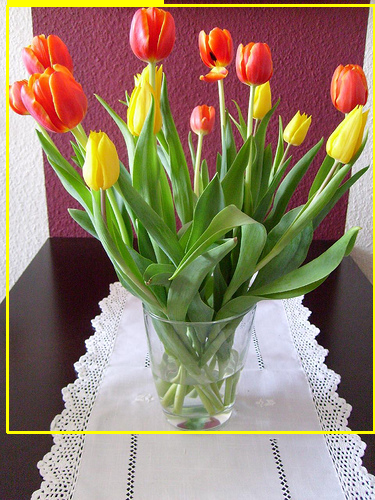

In [ ]:
sample = samples[2]
annotated, detections = pipeline.run(
    sample['image_path'], 
    sample['question'],
    sample['explanation'] 
)

display(annotated)